⚡ Using Apple MPS (Metal GPU) backend
📂 Train samples: 5710 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
📂 Test samples : 1309 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
🚀 Using Inception-V3 Pretrained Backbone

🚀 Training Inception-V3...
[Epoch 01] LR=1.00e-05 | Train Acc=0.7401, Test Acc=0.8739 | Train Loss=1.2000, Test Loss=0.6135 | Test F1=0.8690
💾 New Best Model: F1=0.8690 at Epoch 1
[Epoch 02] LR=1.00e-05 | Train Acc=0.8961, Test Acc=0.9213 | Train Loss=0.7948, Test Loss=0.5013 | Test F1=0.9180
💾 New Best Model: F1=0.9180 at Epoch 2
[Epoch 03] LR=1.00e-05 | Train Acc=0.9301, Test Acc=0.9511 | Train Loss=0.6997, Test Loss=0.4552 | Test F1=0.9494
💾 New Best Model: F1=0.9494 at Epoch 3
[Epoch 04] LR=1.00e-05 | Train Acc=0.9508, Test Acc=0.9649 | Train Loss=0.6628, Test Loss=0.4352 | Test F1=0.9639
💾 New Best Model: F1=0.9639 at Epoch 4
[Epoch 05] LR=1.00e-05 | Train Acc=0.9599, Test Acc=0.9740 | Train Loss=0.6323, Test Loss=0.4191 | Test F1=0.9732
💾 N

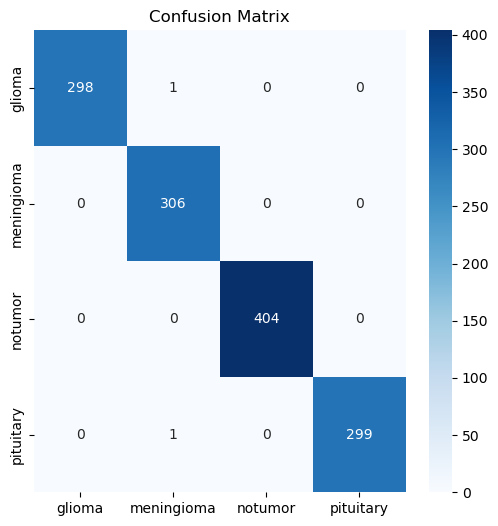

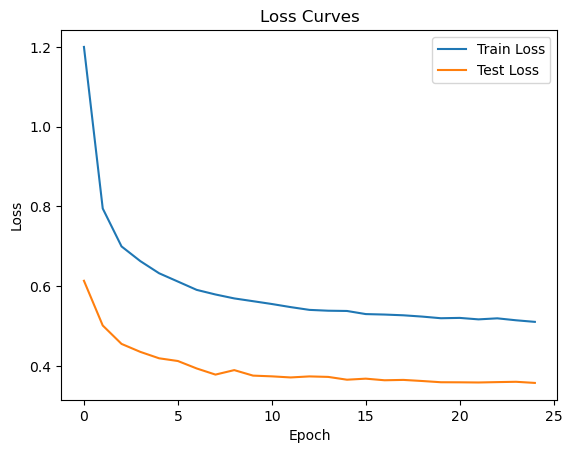

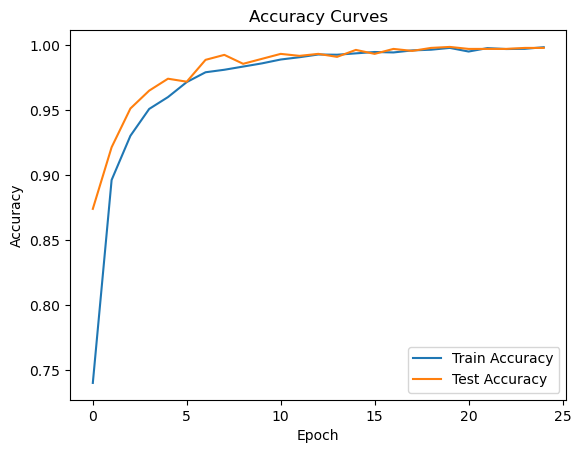

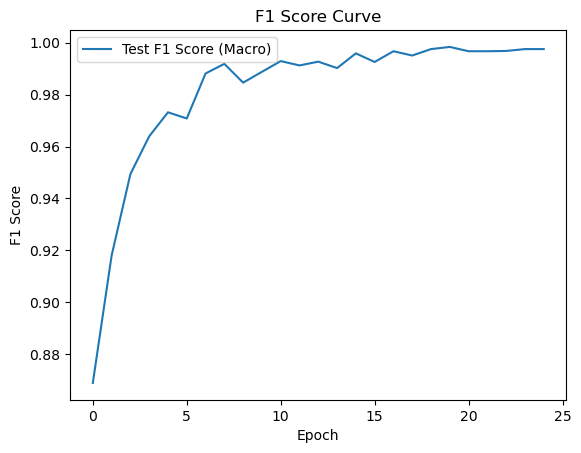

In [1]:
import os, time, warnings, logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================
# SETTINGS
# =====================
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

# Use MPS (Apple GPU) if available
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    logger.info("⚡ Using Apple MPS (Metal GPU) backend")
else:
    DEVICE = torch.device("cpu")
    logger.info("⚠️ MPS not available, using CPU")

BATCH_SIZE = 16
EPOCHS = 50
IMG_SIZE = 299   # Inception-V3 expects 299x299
LR = 1e-5
PATIENCE = 5     # early stopping

TRAIN_DIR = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Training'
TEST_DIR  = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Testing'

# =====================
# DATA TRANSFORMS
# =====================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =====================
# DATASETS & CLASSES
# =====================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transform)

logger.info(f"📂 Train samples: {len(train_dataset)} | Classes: {train_dataset.classes}")
logger.info(f"📂 Test samples : {len(test_dataset)} | Classes: {test_dataset.classes}")

num_classes = len(train_dataset.classes)

# =====================
# BALANCED SAMPLER
# =====================
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
samples_weight = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# =====================
# MODEL: Inception-V3
# =====================
logger.info("🚀 Using Inception-V3 Pretrained Backbone")
model = models.inception_v3(weights="IMAGENET1K_V1", aux_logits=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Auxiliary classifier needs to match too
if model.aux_logits:
    in_features_aux = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(in_features_aux, num_classes)

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.3)

model = model.to(DEVICE)

# =====================
# TRAINING
# =====================
best_f1, patience_counter, best_epoch = 0, 0, 0
train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list, f1_list = [], [], []

start_time = time.time()
logger.info("\n🚀 Training Inception-V3...")

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)

        # Inception returns (main, aux) during training
        if isinstance(outputs, tuple):
            main_out, aux_out = outputs
            loss1 = criterion(main_out, labels)
            loss2 = criterion(aux_out, labels)
            loss = loss1 + 0.4 * loss2
            final_out = main_out
        else:
            loss = criterion(outputs, labels)
            final_out = outputs

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = final_out.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # ---- Evaluation ----
    model.eval()
    y_true, y_pred = [], []
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # main only for eval
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_loss /= len(test_loader)
    test_f1 = f1_score(y_true, y_pred, average="macro")

    # Save metrics
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    f1_list.append(test_f1)

    scheduler.step(test_f1)
    lr = optimizer.param_groups[0]['lr']

    logger.info(f"[Epoch {epoch+1:02d}] LR={lr:.2e} | "
                f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f} | "
                f"Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f} | "
                f"Test F1={test_f1:.4f}")

    # Save best model
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), "best_inception_v3.pth")
        logger.info(f"💾 New Best Model: F1={best_f1:.4f} at Epoch {best_epoch}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            logger.info("⏹ Early stopping.")
            break

elapsed = (time.time()-start_time)/60
logger.info(f"\n⏱ Training finished in {elapsed:.1f} min. Best F1={best_f1:.4f} at epoch {best_epoch}")

# =====================
# LOAD BEST MODEL
# =====================
model.load_state_dict(torch.load("best_inception_v3.pth"))
model.eval()
logger.info("🔄 Loaded best saved Inception-V3 for final evaluation.")

# =====================
# FINAL EVALUATION
# =====================
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # main output only
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = accuracy_score(y_true, y_pred)
final_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
final_rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
final_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

logger.info("\n📊 FINAL PERFORMANCE SUMMARY")
logger.info("===================================")
logger.info(f"✅ Accuracy         : {final_acc*100:.2f}%")
logger.info(f"🎯 Precision (Macro): {final_prec:.4f}")
logger.info(f"📌 Recall    (Macro): {final_rec:.4f}")
logger.info(f"📈 F1-Score  (Macro): {final_f1:.4f}")

# =====================
# CONFUSION MATRIX
# =====================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# =====================
# TRAINING CURVES
# =====================
plt.figure()
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(f1_list, label="Test F1 Score (Macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Curve")
plt.legend()
plt.show()